# Dependecies

In [1]:
import os
import shutil
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload

In [2]:
from npeet import entropy_estimators as ee
from ml_collections import ConfigDict

In [3]:
import sys
sys.path.append('../lib')
from pipelines.SyntheticPipelines.DiffusionSimpleTrainer import SimpleTrainer
from pipelines.SyntheticPipelines.DiffusionSimpleSampler import simple_sampler
from visualization_utils.PlotSS import plot_xt_ss_process
from metrics_and_losses.SimpleMetrics import npeet_symmetric_kl_estimation

from pipelines.fix_seed import fix_seed
from saving_utils.get_repo_root import get_repo_root

2023-11-28 19:05:38.502994: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Experiments pipeline

In [4]:
def training_pipeline(
    config_definition,
    checkpoints_folder,
    results_folder,
    final_model_name,
    seed=12345
):
    # create folder for results
    if not os.path.exists(results_folder):
        os.mkdir(results_folder)

    # train diffusion model
    fix_seed(seed)
    main_config = config_definition()
    main_config.checkpoints_config.folder = checkpoints_folder
    trainer = SimpleTrainer(main_config)
    trainer.train(
        method=main_config.sampling_procedure,
        num_iters=375000,
        ema_val_max_iters=100,
        device=3,
        num_workers=5,
        graphics_path=results_folder
    )

    # save final model
    last_checkpoint = os.path.join(
        main_config.checkpoints_config.folder, 'MLP_episode0_epoch350000_model.pt'
    )
    shutil.copyfile(
        os.path.join(get_repo_root(), 'checkpoints', last_checkpoint),
        os.path.join(get_repo_root(), 'pretrained_models', final_model_name)
    )
    pass



def sampling_pipeline(
    config_definition,
    final_model_name,
    seed=12345
):
    # load pretrained model
    fix_seed(seed)
    main_config = config_definition()
    main_config.model_config = ConfigDict({
        'model_name' : 'MLP',
        'model_config' : ConfigDict({
            'pretrained_model' : final_model_name
        })
    })
    main_config.checkpoints_config = None
    trainer = SimpleTrainer(main_config)
    trainer.load(method=main_config.sampling_procedure)
    
    # sample from dataset and diffusion model
    num_samples = 100000
    q_samples = trainer.dataset.sample('train', num_samples)
    p_samples = simple_sampler(
        trainer.model,
        trainer.diffusion,
        num_samples,
        20000
    )
    return q_samples, p_samples

# Positive Definite Matrices 2x2

In [5]:
from visualization_utils.PlotManifolds import pdm2x2_plot, plot_pdm2x2_result

# define and create folder for results
pdm2x2_folder = os.path.join(get_repo_root(), 'results', 'pdm2x2')
def pdm2x2_path(path):
    return os.path.join(pdm2x2_folder, path)
if not os.path.exists(pdm2x2_folder):
    os.mkdir(pdm2x2_folder)

## Configs

In [6]:
def shared_config():
    dataset_config = ConfigDict({
        'type' : 'pdm_2x2',
        'dataset' : 'm1',
        'size' : 'inf',
        'split' : None,
        'batch_size' : 128
    })
    model_config = ConfigDict({
        'model_name' : 'MLP',
        'model_config' : ConfigDict({
            'default' : 'mlp-ellipse'
        })
    })
    optimizer_config = ConfigDict({
        'optimizer' : {
            'method' : 'Adam',
            'config' : { 'lr' : 4e-4 }
        },
        'ema' : {
            'ema_rate' : 0.9998,
            'initial_acceleration' : True
        },
        'clip_grad_norm' : 1.0
    })
    checkpoints_config = ConfigDict({
        'folder' : None,
        'saving_freq' : 25000,
        'reset_previous' : True
    })
    main_config = ConfigDict({
        'dataset_config' : dataset_config,
        'model_config' : model_config,
        'metrics_config' : [
                ConfigDict({
                    'metric' : 'loss',
                    'freq' : 100
                }),
                ConfigDict({
                    'metric' : 'npeet_kl',
                    'freq' : 25000,
                    'num_estimations' : 4,
                    'num_samples' : 100000,
                    'batch_size' : 20000
                })
        ],
        'optimizer_config' : optimizer_config,
        'checkpoints_config' : checkpoints_config,
        'norm_samples' : 2000,
        'ema_val_freq' : 5000,
        'ema_val_max_iters' : 100,
        'show_freq' : 2500,
        'use_norm' : True
    })
    return main_config




def ss_config():
    config = shared_config()
    config.diffusion_config = ConfigDict({
        'method'       : 'WishartStarShaped',
        'object_shape' : (1, 2, 2),
        'num_steps'    : 64,
        'scheduler'    : 'default_wishart'
    })
    config.sampling_procedure = 'ss'
    config.loss_config = ConfigDict({ 'method' : 'KL_rescaled' })
    return config




def ddpm_config():
    config = shared_config()
    config.diffusion_config = ConfigDict({
        'method'       : 'SyntheticDDPM',
        'object_shape' : (1, 2, 2),
        'num_steps'    : 64,
        'scheduler'    : 'cosine',
        'use_norm'     : True
    })
    config.sampling_procedure = 'ddpm'
    config.loss_config = ConfigDict({ 'method' : 'KL_rescaled' })
    return config

## Wishart-SS-DDPM

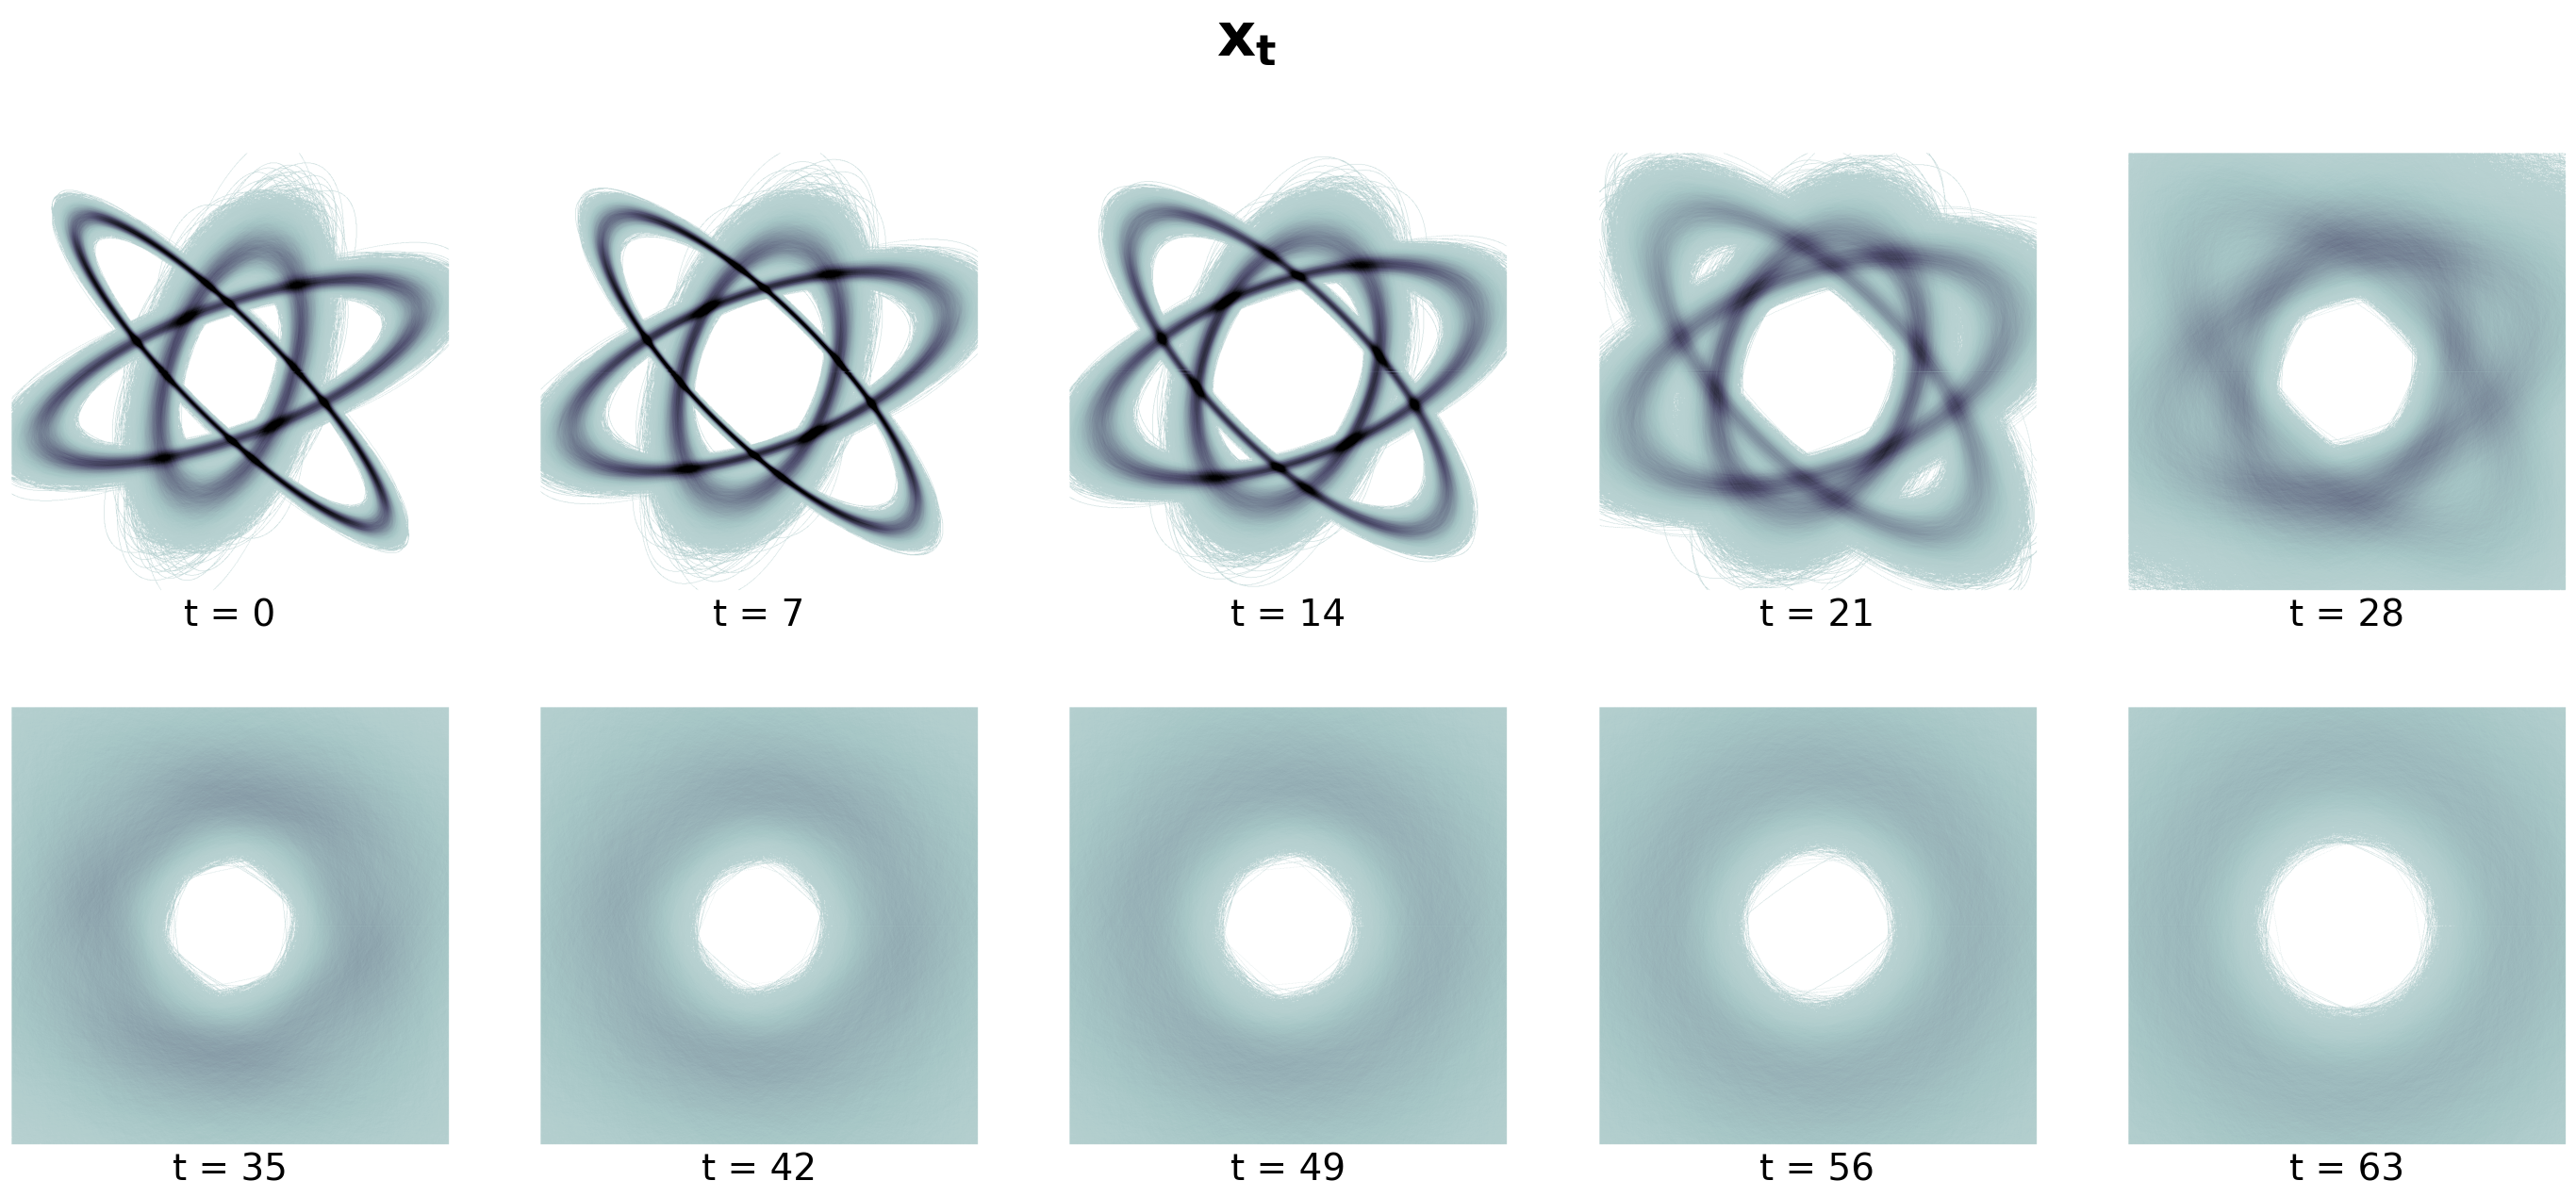

In [7]:
main_config = ss_config()
main_config.checkpoints_config = None
trainer = SimpleTrainer(main_config)
plot_xt_ss_process(
    ss=trainer.diffusion, 
    num_objects=50000, 
    dataset=trainer.dataset,
    manifold_visualization=pdm2x2_plot,
    fpath=pdm2x2_path('WishartXt.pdf')
)

In [8]:
"""
training_pipeline(
    config_definition=ss_config,
    checkpoints_folder='ellipse-mixture_wishart-ss',
    results_folder=pdm2x2_path('wishart-ss'),
    final_model_name='mlp-ellipse_wishart-ss.pt'
)
"""

"\ntraining_pipeline(\n    config_definition=ss_config,\n    checkpoints_folder='ellipse-mixture_wishart-ss',\n    results_folder=pdm2x2_path('wishart-ss'),\n    final_model_name='mlp-ellipse_wishart-ss.pt'\n)\n"

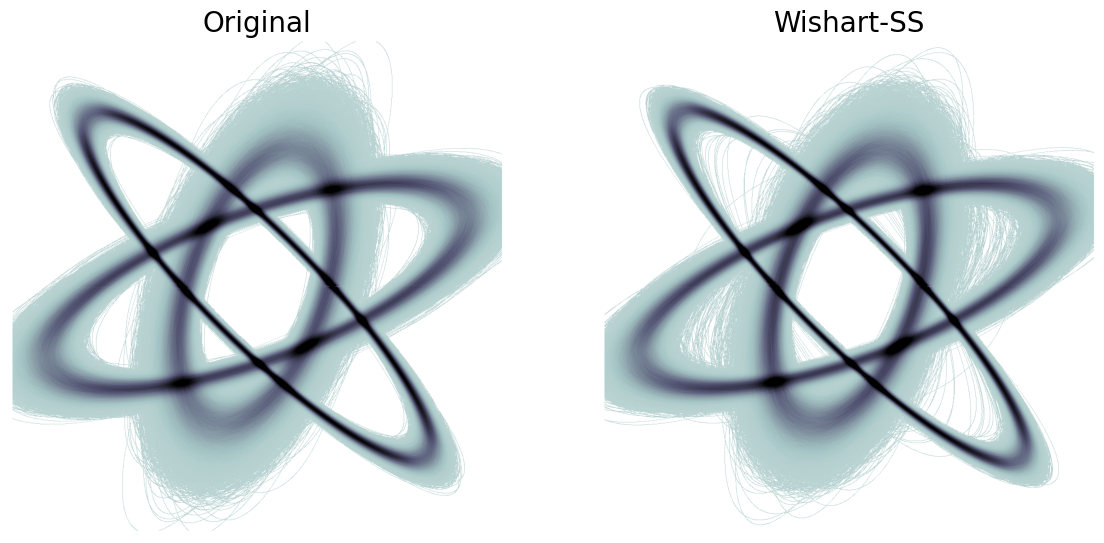

symmetric kl: 0.059


In [9]:
original_obj, generated_obj = sampling_pipeline(
    config_definition=ss_config,
    final_model_name='mlp-ellipse_wishart-ss.pt'
)

# check quality
plot_pdm2x2_result(original_obj, generated_obj, 'Wishart-SS')
sym_kl_estim = npeet_symmetric_kl_estimation(original_obj, generated_obj)
print(f'symmetric kl: {sym_kl_estim:5.3f}')

## DDPM

In [10]:
"""
training_pipeline(
    config_definition=ddpm_config,
    checkpoints_folder='ellipse-mixture_ddpm',
    results_folder=pdm2x2_path('ddpm'),
    final_model_name='mlp-ellipse_ddpm.pt'
)
"""

"\ntraining_pipeline(\n    config_definition=ddpm_config,\n    checkpoints_folder='ellipse-mixture_ddpm',\n    results_folder=pdm2x2_path('ddpm'),\n    final_model_name='mlp-ellipse_ddpm.pt'\n)\n"

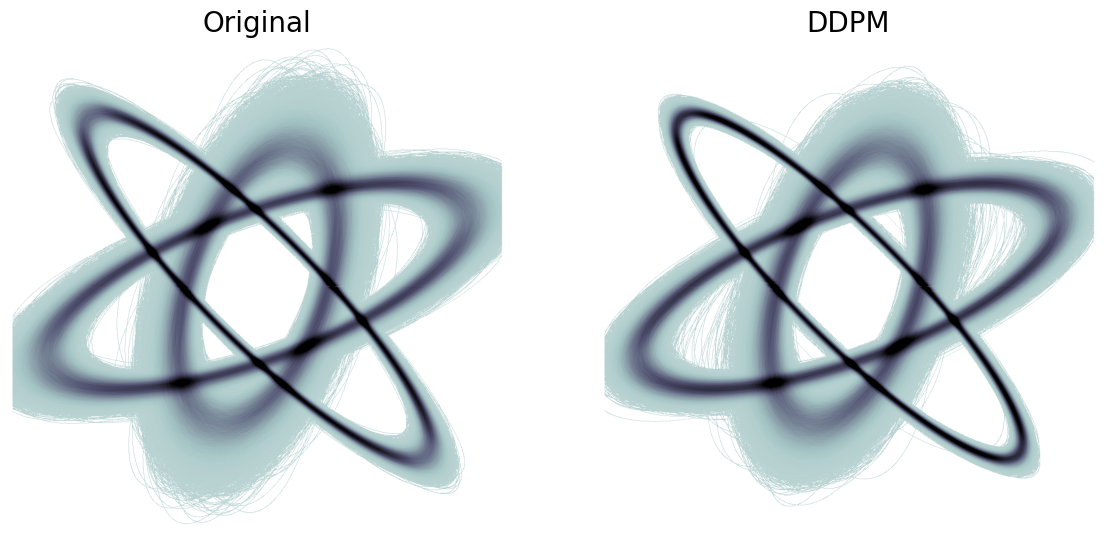

symmetric kl: 0.081


In [11]:
original_obj, generated_obj = sampling_pipeline(
    config_definition=ddpm_config,
    final_model_name='mlp-ellipse_ddpm.pt'
)

# check quality
plot_pdm2x2_result(original_obj, generated_obj, 'DDPM')
sym_kl_estim = npeet_symmetric_kl_estimation(original_obj, generated_obj)
print(f'symmetric kl: {sym_kl_estim:5.3f}')

# Simplex

In [12]:
from visualization_utils.PlotManifolds import simplex_plot, plot_simplex_result

simplex_folder = os.path.join(get_repo_root(), 'results', 'simplex')
def simplex_path(path):
    return os.path.join(simplex_folder, path)
if not os.path.exists(simplex_folder):
    os.mkdir(simplex_folder)

## Configs

In [13]:
def shared_config():
    dataset_config = ConfigDict({
        'type' : 'simplex',
        'dataset' : 'm1',
        'size' : 'inf',
        'split' : None,
        'batch_size' : 128
    })
    model_config = ConfigDict({
        'model_name' : 'MLP',
        'model_config' : ConfigDict({
            'default' : 'mlp-simplex'
        })
    })
    optimizer_config = ConfigDict({
        'optimizer' : {
            'method' : 'Adam',
            'config' : { 'lr' : 4e-4 }
        },
        'ema' : {
            'ema_rate' : 0.9998,
            'initial_acceleration' : True,
            'ema_on_cpu' : True
        },
        'clip_grad_norm' : 1.0
    })
    checkpoints_config = ConfigDict({
        'folder' : None,
        'saving_freq' : 25000,
        'reset_previous' : True
    })
    main_config = ConfigDict({
        'dataset_config' : dataset_config,
        'model_config' : model_config,
        'metrics_config' : [
                ConfigDict({
                    'metric' : 'loss',
                    'freq' : 100
                }),
                ConfigDict({
                    'metric' : 'npeet_kl',
                    'freq' : 25000,
                    'num_estimations' : 4,
                    'num_samples' : 100000,
                    'batch_size' : 20000
                })
        ],
        'optimizer_config' : optimizer_config,
        'checkpoints_config' : checkpoints_config,
        'norm_samples' : 2000,
        'ema_val_freq' : 5000,
        'ema_val_max_iters' : 100,
        'show_freq' : 2500
    })
    return main_config




def ss_config():
    config = shared_config()
    config.diffusion_config = ConfigDict({
        'method'       : 'DirichletStarShaped',
        'object_shape' : (1, 1, 3),
        'num_steps'    : 64,
        'scheduler'    : 'default_dirichlet'
    })
    config.sampling_procedure = 'ss'
    config.loss_config = ConfigDict({ 'method' : 'KL' })
    return config
    
    

    
def ddpm_config():
    config = shared_config()
    config.diffusion_config = ConfigDict({
        'method'       : 'SyntheticDDPM',
        'object_shape' : (1, 1, 3),
        'num_steps'    : 64,
        'scheduler'    : 'cosine',
        'use_norm'     : True
    })
    config.sampling_procedure = 'ddpm'
    config.loss_config = ConfigDict({ 'method' : 'KL_rescaled' })
    return config

## Dirichlet-SS-DDPM

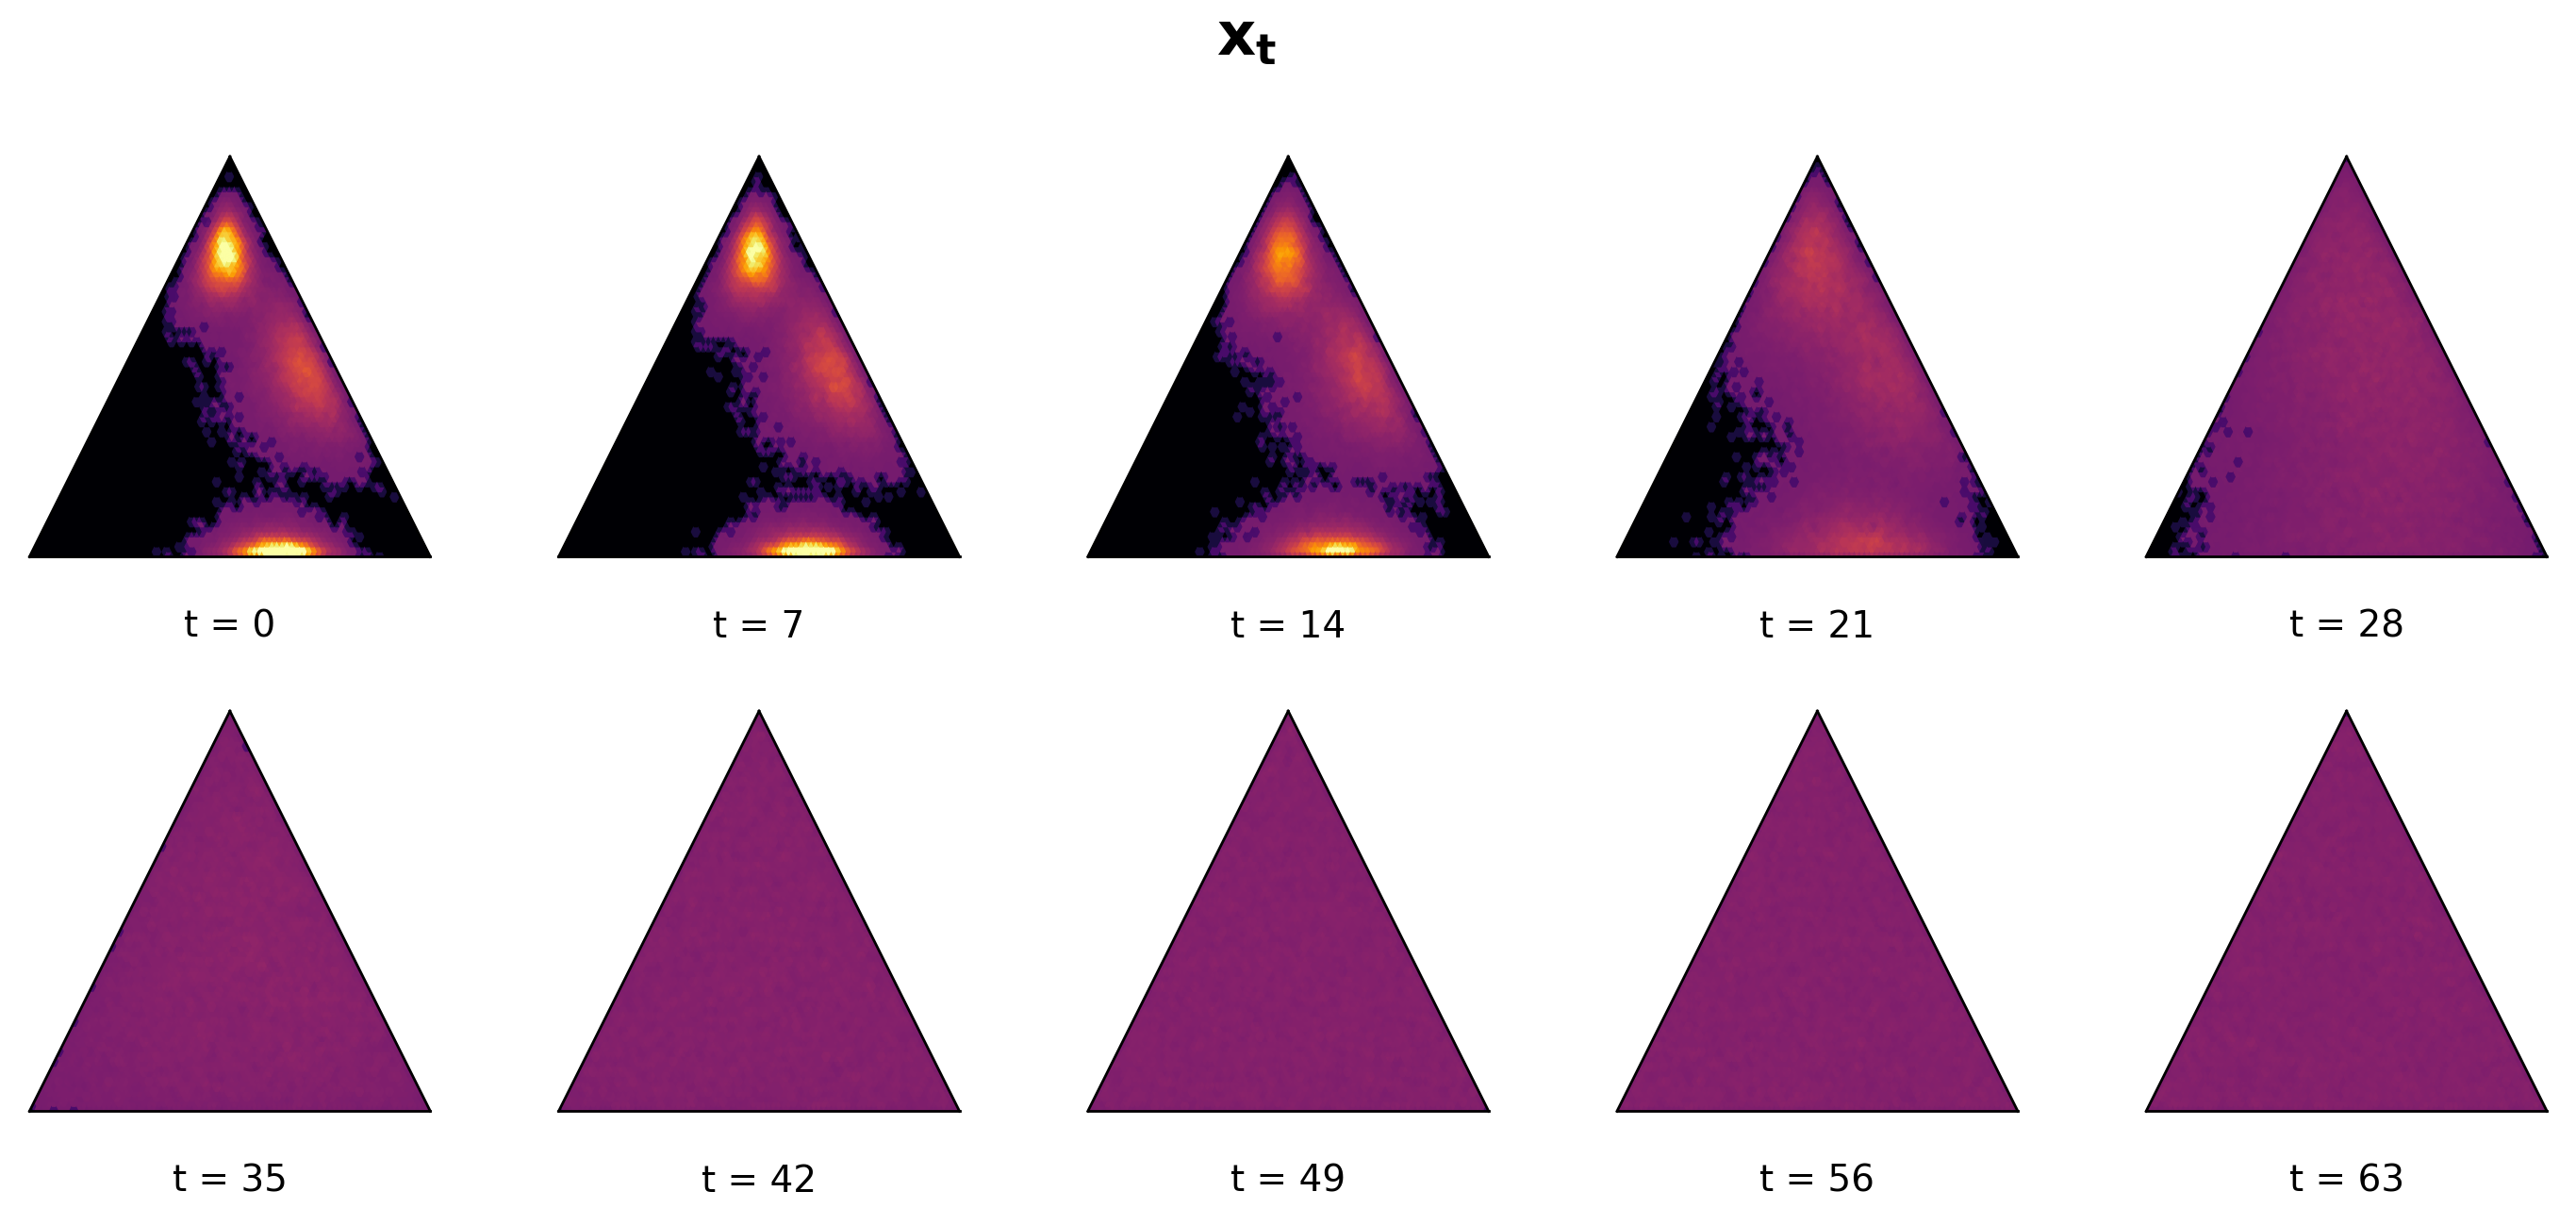

In [14]:
main_config = ss_config()
main_config.checkpoints_config = None
trainer = SimpleTrainer(main_config)
plot_xt_ss_process(
    ss=trainer.diffusion, 
    num_objects=50000, 
    dataset=trainer.dataset,
    manifold_visualization=simplex_plot,
    fpath=simplex_path('dirichlet-ss_forward-process.png')
)

In [15]:
"""
training_pipeline(
    config_definition=ss_config,
    checkpoints_folder='simplex-mixture_dirichlet-ss',
    results_folder=simplex_path('dirichlet-ss'),
    final_model_name='mlp-simplex_dirichlet-ss.pt'
)
"""

"\ntraining_pipeline(\n    config_definition=ss_config,\n    checkpoints_folder='simplex-mixture_dirichlet-ss',\n    results_folder=simplex_path('dirichlet-ss'),\n    final_model_name='mlp-simplex_dirichlet-ss.pt'\n)\n"

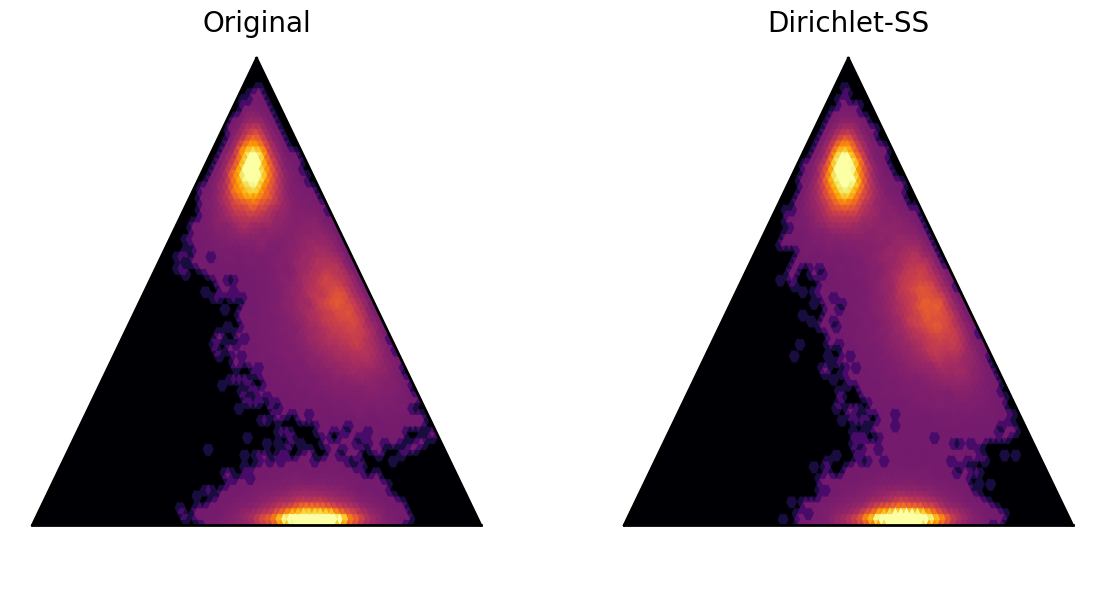

symmetric kl: 0.016


In [16]:
original_obj, generated_obj = sampling_pipeline(
    config_definition=ss_config,
    final_model_name='mlp-simplex_dirichlet-ss.pt'
)

# check quality
plot_simplex_result(original_obj, generated_obj, 'Dirichlet-SS')
sym_kl_estim = npeet_symmetric_kl_estimation(original_obj, generated_obj)
print(f'symmetric kl: {sym_kl_estim:5.3f}')

## DDPM

In [17]:
"""
training_pipeline(
    config_definition=ddpm_config,
    checkpoints_folder='simplex-mixture_ddpm',
    results_folder=simplex_path('ddpm'),
    final_model_name='mlp-simplex_ddpm.pt'
)
"""

"\ntraining_pipeline(\n    config_definition=ddpm_config,\n    checkpoints_folder='simplex-mixture_ddpm',\n    results_folder=simplex_path('ddpm'),\n    final_model_name='mlp-simplex_ddpm.pt'\n)\n"

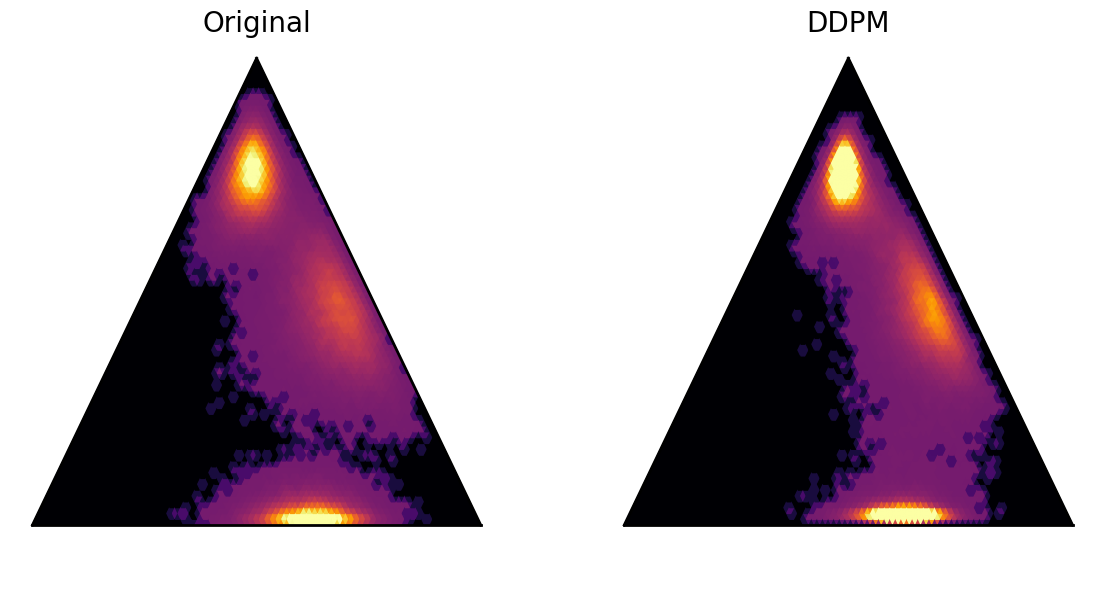

symmetric kl: 0.431


In [18]:
original_obj, generated_obj = sampling_pipeline(
    config_definition=ddpm_config,
    final_model_name='mlp-simplex_ddpm.pt'
)

# check quality
plot_simplex_result(original_obj, generated_obj, 'DDPM')
sym_kl_estim = npeet_symmetric_kl_estimation(original_obj, generated_obj)
print(f'symmetric kl: {sym_kl_estim:5.3f}')